In [41]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import LabelEncoder
from io import StringIO
from sklearn.model_selection import KFold
from oldslidingWindow import read_data, segment_data_by_day, sliding_window
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)

# UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

REAL_DATA = '../Processed Data/Aruba_17/processed_data.csv'
FAKE_DATA = '../Predictions/Aruba_17_prediction_419.txt'

# Read the data as a string and split it by lines
with open(REAL_DATA, 'r') as f:
    lines = f.read().splitlines()

lines = lines[1:]
data_str = '\n'.join(lines)
data_df = pd.read_csv(StringIO(data_str), delimiter=',', header=None, dtype=float)

# Read the data as a string and split it by lines
with open(FAKE_DATA, 'r') as f:
    lines = f.read().splitlines()

fake_data_str = '\n'.join(lines)
fake_data_df = pd.read_csv(StringIO(fake_data_str), delimiter=',', header=None, dtype=float)

daily_segments_real = segment_data_by_day(data_df)
daily_segments_fake = segment_data_by_day(fake_data_df)
# only use the first 100 days of data
daily_segments_real = daily_segments_real[:100]
daily_segments_fake = daily_segments_fake[:100]

def create_day_segments_with_labels(segmented_data):
    day_segments = []
    for day in segmented_data:
        day_data = day.iloc[:, :6].to_numpy()
        day_labels = day.iloc[:, 4:].astype(str).apply(lambda x: '_'.join(x), axis=1).to_numpy()
        day_segments.append({'data': day_data, 'labels': day_labels})
    return day_segments

day_segments_real = create_day_segments_with_labels(daily_segments_real)
day_segments_fake = create_day_segments_with_labels(daily_segments_fake)

def evaluate_classifier(day_segments):
    all_reports = []
    balanced_accuracies = []

    best_f1_score = -1
    best_cm = None
    best_test_labels = None

    for i, test_day in enumerate(day_segments):
        train_days = [d for j, d in enumerate(day_segments) if j != i]
        X_train = np.concatenate([d['data'] for d in train_days], axis=0)
        y_train = np.concatenate([d['labels'] for d in train_days], axis=0)
        X_test = test_day['data']
        y_test = test_day['labels']

        label_encoder = LabelEncoder()
        y_train_encoded = label_encoder.fit_transform(y_train)
        y_test_encoded = label_encoder.transform(y_test)

        clf = RandomForestClassifier(n_jobs=-1, n_estimators=50, min_samples_leaf=20)
        clf.fit(X_train, y_train_encoded)

        y_pred = clf.predict(X_test)

        weighted_precision, weighted_recall, weighted_fscore, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average='weighted')
        bal_acc = balanced_accuracy_score(y_test_encoded, y_pred)
        report = {"weighted_precision": weighted_precision, "weighted_recall": weighted_recall, "weighted_fscore": weighted_fscore}
        all_reports.append(report)
        balanced_accuracies.append(bal_acc)

        if weighted_fscore > best_f1_score:
            best_f1_score = weighted_fscore
            best_cm = confusion_matrix(y_test_encoded, y_pred)
            best_test_labels = np.unique(y_test)


    mean_report = pd.DataFrame(all_reports).mean()
    mean_balanced_accuracy = np.mean(balanced_accuracies)

    return best_cm, best_test_labels, mean_report, mean_balanced_accuracy

def plot_confusion_matrix(cm, labels):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(include_values=True, cmap=plt.cm.Blues, ax=None, xticks_rotation='vertical')
    plt.show()

### QUANTITATIVE ANALYSIS ###

C:\Users\Alec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Alec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
C:\Users\Alec\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:2006: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


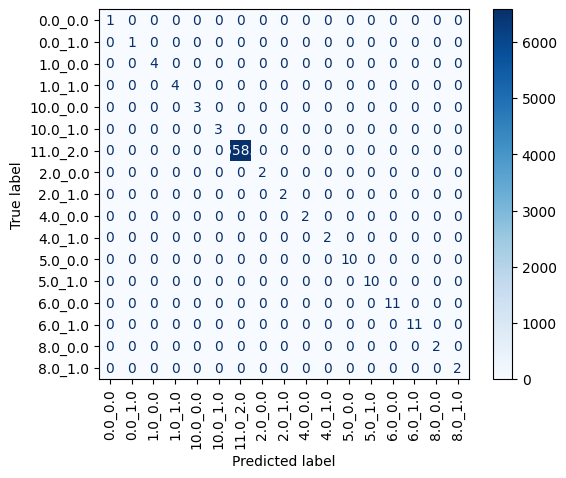

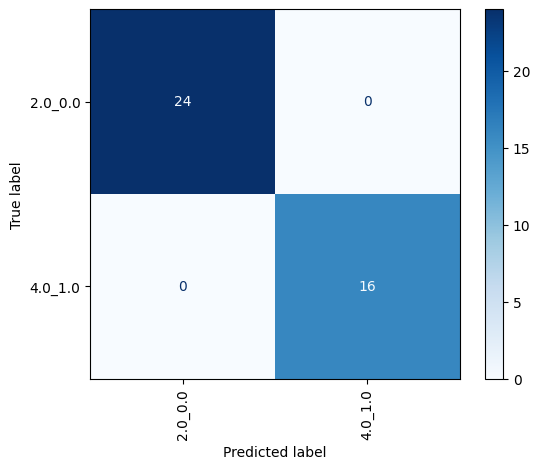

Real dataset results: 
 weighted_precision    0.999843
weighted_recall       0.999891
weighted_fscore       0.999860
dtype: float64
Fake dataset results: 
 weighted_precision    0.929126
weighted_recall       0.946119
weighted_fscore       0.932301
dtype: float64
Reak Balanced Accuracy:  0.9688805301967841
Fake Balanced Accuracy:  0.7826879910213244


In [42]:

# Call the evaluation function for both datasets
real_best_cm, real_best_test_labels, real_results, real_balanced_accuracy = evaluate_classifier(day_segments_real)
fake_best_cm, fake_best_test_labels, fake_results, fake_balanced_accuracy = evaluate_classifier(day_segments_fake)


plot_confusion_matrix(real_best_cm, real_best_test_labels)
plot_confusion_matrix(fake_best_cm, fake_best_test_labels)

print("Real dataset results: \n", real_results)
print("Fake dataset results: \n", fake_results)
print("Reak Balanced Accuracy: ", real_balanced_accuracy)
print("Fake Balanced Accuracy: ", fake_balanced_accuracy)

### QUALITATIVE ANALYSIS ###

In [37]:
def activity_counts(data, activity_column):
    counts = data.iloc[:, activity_column].value_counts()
    counts = counts / 2
    return counts
def activity_proportions(counts):
    proportions = counts / counts.sum()
    return proportions
def activity_entropy(proportions):
    entropy = -np.sum(proportions * np.log2(proportions))
    return entropy

# print the 4 column of the data
real_counts = activity_counts(data_df, 4)
generated_counts = activity_counts(fake_data_df, 4)

real_proportions = activity_proportions(real_counts)
generated_proportions = activity_proportions(generated_counts)

real_entropy = activity_entropy(real_proportions)
generated_entropy = activity_entropy(generated_proportions)

# print("Real data entropy:", real_entropy)
# print("Generated data entropy:", generated_entropy)
# print("Real Activity Counts:", real_counts)
# print("Generated Activity Counts:", generated_counts)
# print("Real Activity Proportions:", real_proportions)
# print("Generated Activity Proportions:", generated_proportions)

comparison_df = pd.DataFrame(columns=["Metric", "Real Data", "Generated Data"])

comparison_df = comparison_df.append(
    {"Metric": "Entropy", "Real Data": real_entropy, "Generated Data": generated_entropy},
    ignore_index=True,
)

for activity in real_counts.index:
    comparison_df = comparison_df.append(
        {
            "Metric": f"Count ({activity})",
            "Real Data": real_counts[activity],
            "Generated Data": generated_counts.get(activity, 0),
        },
        ignore_index=True,
    )

for activity in real_proportions.index:
    comparison_df = comparison_df.append(
        {
            "Metric": f"Proportion ({activity})",
            "Real Data": real_proportions[activity],
            "Generated Data": generated_proportions.get(activity, 0),
        },
        ignore_index=True,
    )

print(comparison_df)

C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykern

               Metric Real Data Generated Data
0             Entropy  0.081679       2.003002
1        Count (11.0)  853292.0              0
2         Count (6.0)    2918.5        59522.0
3         Count (5.0)    1605.5        86054.0
4         Count (4.0)     431.0        28965.0
5         Count (2.0)     431.0           46.5
6         Count (8.0)     401.0         5492.0
7         Count (1.0)     257.0            8.0
8        Count (10.0)     171.0              0
9         Count (0.0)     157.0              0
10        Count (9.0)      65.0              0
11        Count (3.0)      33.0           77.5
12        Count (7.0)       6.0        36205.0
13  Proportion (11.0)  0.992468              0
14   Proportion (6.0)  0.003395       0.275094
15   Proportion (5.0)  0.001867       0.397717
16   Proportion (4.0)  0.000501       0.133868
17   Proportion (2.0)  0.000501       0.000215
18   Proportion (8.0)  0.000466       0.025382
19   Proportion (1.0)  0.000299       0.000037
20  Proportio

C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykernel_33692\3337097639.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comparison_df = comparison_df.append(
C:\Users\Alec\AppData\Local\Temp\ipykern